In [1]:
import tensorflow as tf
import numpy as np

In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [3]:
from sklearn import metrics
from scipy import stats
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [4]:
import pandas as pd

In [5]:
data = pd.read_csv('Preprocessed raw data.csv')

In [6]:
X = data['Consumer complaint narrative']

In [7]:
y = data['Consumer disputed?']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8,test_size=0.2,stratify=y)

In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import re

[nltk_data] Downloading package stopwords to C:\Users\Pranav
[nltk_data]     Bhardwaj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [11]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words and not re.fullmatch(r"^\d+$",token) and not re.fullmatch(r"^x+$",token):
      if stem:
        tokens.append(stemmer.stem(token))
      else:
         tokens.append(token)
  return " ".join(tokens)

In [12]:
X = X.apply(lambda x: preprocess(x))

In [13]:
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 200

In [14]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 70338


In [15]:
from keras.utils import pad_sequences
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train),
                        maxlen = MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test),
                       maxlen = MAX_SEQUENCE_LENGTH)

In [16]:
y_train = pd.get_dummies(y_train)

In [17]:
GLOVE_EMB = 'glove.6B.200d.txt'
EMBEDDING_DIM = 200
LR = 1e-2
BATCH_SIZE = 1000
EPOCHS = 10

In [18]:
embeddings_index = {}

f = open(GLOVE_EMB, encoding='cp437')
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400001 word vectors.


In [19]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [20]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

In [21]:
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, SimpleRNN, LSTM, GRU, Bidirectional, Dense 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import plot_model
from keras.initializers import Constant

In [22]:
def plot_model_learning(history, title):
    fig, ax = plt.subplots(2, 1, figsize=(20, 8))
    df = pd.DataFrame(history.history)
    df[['accuracy', 'val_accuracy']].plot(ax=ax[0])
    df[['loss', 'val_loss']].plot(ax=ax[1])
    ax[0].set_title('Model Accuracy', fontsize=12)
    ax[1].set_title('Model Loss', fontsize=12)
    fig.suptitle(f'{title}: Model Metrics', fontsize=18)

In [23]:
from tensorflow.keras.layers import Conv1D, Dense, Input, Dropout

In [24]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(GRU(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(200, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(200, activation='relu')(x)
outputs = Dense(2, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [25]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
filepath = "model.h5"
ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
rlp = ReduceLROnPlateau(monitor='loss', patience=3, verbose=1)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()
plot_model(model, show_shapes=True)

history = model.fit(x=X_train, y=y_train, batch_size=BATCH_SIZE, validation_split=0.1,
    callbacks=[es, ckpt, rlp], epochs=EPOCHS
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 200)          14067600  
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 200)         0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 196, 64)           64064     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              49920     
 l)                                                              
                                                                 
 dense (Dense)               (None, 200)               25800 

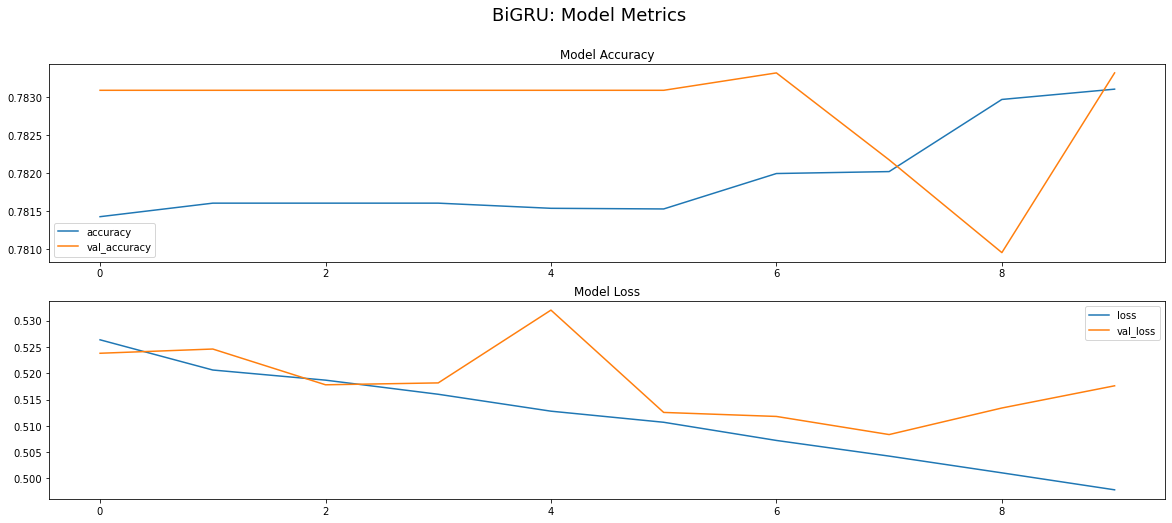

In [26]:
plot_model_learning(history, 'BiGRU')

In [27]:
def decode_sentiment(score):
    return "No" if score[0]>score[1] else "Yes"


scores = model.predict(X_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

4/4 [==============================] - 73s 17s/step


In [28]:
print(classification_report(y_test.to_list(), y_pred_1d))

              precision    recall  f1-score   support

          No       0.78      0.99      0.88     25651
         Yes       0.44      0.02      0.03      7162

    accuracy                           0.78     32813
   macro avg       0.61      0.51      0.45     32813
weighted avg       0.71      0.78      0.69     32813

